# Final Project – Module 1

### Import packages and datasets that will be used throughout investigation

In [26]:
#--- IMPORT NECESSARY PACKAGES ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pandasql import sqldf

#--- BASIC GLOBAL DECLARATIONS ---
pysqldf = lambda q: sqldf(q, globals())
%matplotlib inline

In [27]:
#--- IMPORT DATA FROM EXTERNAL CSVs ---

# basic title data from IMDb
path = os.path.join('data','imdb.title.basics.csv')
imdb_title_basics = pd.read_csv(path)

# review data from IMDb
path = os.path.join('data','imdb.title.ratings.csv')
imdb_title_ratings = pd.read_csv(path)

# movie basic details from Rotten Tomatoes
path = os.path.join('data','rt.movie_info.tsv')
rt_movie_info = pd.read_csv(path, delimiter = '\t')

# review data from Rotten Tomatoes
path = os.path.join('data','rt.reviews.tsv')
rt_reviews = pd.read_csv(path, delimiter = '\t', encoding= 'unicode_escape')

# wide ranging data from The Movie Database, largely used for popularity ratings
path = os.path.join('data','tmdb.movies.csv')
tmdb_movies = pd.read_csv(path).drop('Unnamed: 0', axis=1)

# budget data from The Numbers
path = os.path.join('data','tn.movie_budgets.csv')
tn_movie_budgets = pd.read_csv(path)

In [28]:
#--- COMBINE AND CLEAN FINANCIAL DATA ---

finance = tn_movie_budgets[['movie', 'production_budget', 
                            'domestic_gross','worldwide_gross']].copy()

# clean data: remove '$' and ',' then convert to float
production_budget = [float(x.replace('$', '').replace(',','')) for x in finance.production_budget] 
domestic_gross = [float(x.replace('$', '').replace(',','')) for x in finance.domestic_gross]
worldwide_gross = [float(x.replace('$', '').replace(',','')) for x in finance.worldwide_gross]

# input recently cleaned data back into finance dataframe
finance['production_budget'] = production_budget
finance['domestic_gross'] = domestic_gross
finance['worldwide_gross'] = worldwide_gross

# calculate profit as gross revenue minus production budget
finance['profit'] = finance['worldwide_gross'] - finance['production_budget']

In [29]:
#--- CREATE LIST OF ALL POSSIBLE GENRES --- 

# Note: the current formatting shows multiple genres in each 
#       genre cell, separated by commas. The below analysis
#       instead creates a separate column for each genre and
#       represents the data as binary 1 or 0 to indicate whether
#       a given film is classified within that genre

genres_messy = imdb_title_basics['genres'].dropna().unique()
genres_clean = []
for genre in genres_messy:
    for genre_split in genre.split(','):
        genres_clean.append(genre_split)
genres_clean = list(set(genres_clean))


df_genres = imdb_title_basics.loc[imdb_title_basics['genres'].isna() == False].copy()
for colname in genres_clean:
    df_genres[colname] = [colname in x for x in df_genres['genres']]

In [30]:
#--- DROP COLUMNS UNWANTED IN FINAL DATAFRAME ---

# Note that this should be kept in a separate cell since running it
# multiple times results in an error if the column is already dropped

imdb_title_basics.drop(['original_title', 'genres'], 
                       axis=1, inplace=True)

tmdb_movies.drop(['original_title', 'id', 'genre_ids', 
                  'original_language'], axis=1, inplace=True)

df_genres.drop(['start_year', 'runtime_minutes', 'genres', 
                'original_title', 'primary_title'], axis=1, inplace=True)

# renaming now makes future SQL join cleaner
finance = finance.rename(columns = {'movie': 'primary_title'})
tmdb_movies = tmdb_movies.rename(columns = {'title': 'primary_title'})


In [31]:
#--- CREATE DATAFRAME THAT AGGREGATES ALL RELEVANT DATA FROM ALL RELEVANT SOURCES ---
q = '''
SELECT * FROM imdb_title_basics
LEFT JOIN finance USING (primary_title) 
LEFT JOIN tmdb_movies USING (primary_title)
LEFT JOIN df_genres USING (tconst);'''

# Use SQL to connect relevant dataframes
all_data = pysqldf(q)

genre_dict = {
'Action': 'genre_action',
'Adult': 'genre_adult',
'Adventure': 'genre_adventure',
'Animation': 'genre_animation',
'Biography': 'genre_biography',
'Comedy': 'genre_comedy',
'Crime': 'genre_crime',
'Documentary': 'genre_documentary',
'Drama': 'genre_drama',
'Family': 'genre_family',
'Fantasy': 'genre_fantasy',
'Game-Show': 'genre_gameshow',
'History': 'genre_history',
'Horror': 'genre_horror',
'Music': 'genre_music',
'Musical': 'genre_musical',
'Mystery': 'genre_mystery',
'News': 'genre_news',
'Reality-TV': 'genre_realitytv',
'Romance': 'genre_romance',
'Sci-Fi': 'genre_scifi',
'Short': 'genre_short',
'Sport': 'genre_sport',
'Talk-Show': 'genre_talkshow',
'Thriller': 'genre_thriller',
'War': 'genre_war',
'Western': 'genre_western',
}

#update column names using above dictionary
col_names = []
for col in all_data.columns:
    if col in genre_dict.keys():
        col_names.append(genre_dict[col])
    else:
        col_names.append(col)
all_data.columns = col_names


# convert "None" values/types to NaN for easier manipulation and consistency
all_data.fillna(value=np.nan, inplace=True) 

# Begin Analysis of Data

In [32]:
#list columns containing genre data
GENRES = list(genre_dict.values())


#declare dictionaries to be filled
profit_mean = {}
profit_median = {}

#calculate the mean and median profit for each genre
for g in GENRES:
    profit = all_data.loc[
                        (all_data[g].isna() == False) &
                        (all_data.profit.isna() == False) &
                        (all_data[g] == True), 
                        'profit']
    if str(profit.mean()) != 'nan':
        profit_median[g[6:]] = round(profit.median(), 2)
        profit_mean  [g[6:]] = round(profit.mean(), 2)

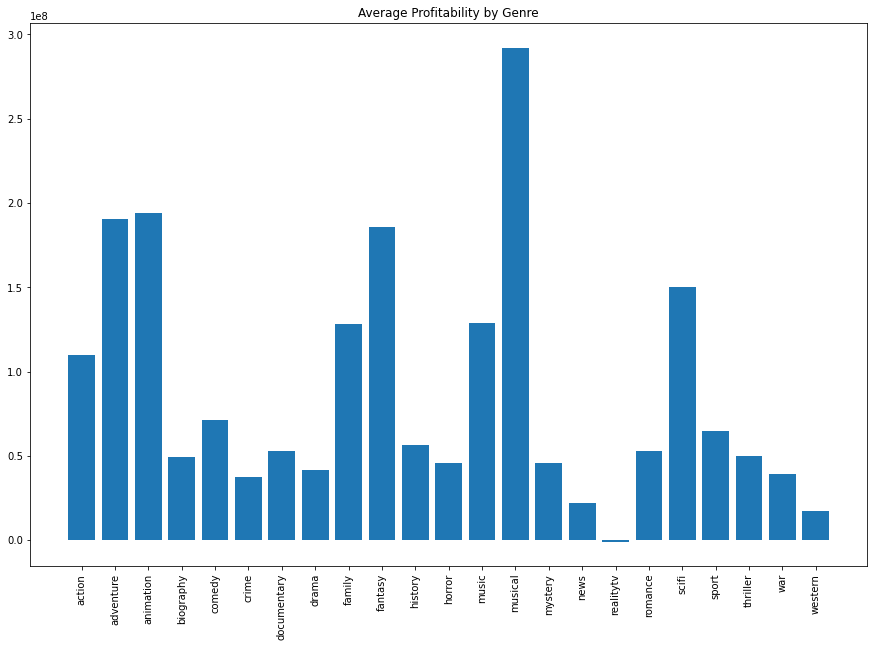

In [33]:
plt.figure(figsize=(15,10))
plt.bar(list(profit_mean.keys()), list(profit_mean.values()))
plt.xticks(rotation=90)
plt.title('Average Profitability by Genre')
plt.show()

-
-
-
-
-
-
-
-
-
-
-

# Popularity

### It's about creating a name for the company, not just immediate profitability

In [ ]:
all_data.columns

In [ ]:
##### CREATE TEMPLATE (almost function) FOR MEAN AND MEDIAN CALCS #####

CATEGORY = 'profit'

#loop through full database, aggregating data by genre
mean = {}
median = {}
for g in GENRES:
    temp = all_data.loc[
                        (all_data[g].isna() == False) &
                        (all_data[CATEGORY].isna() == False) &
                        (all_data[g] == True), 
                        CATEGORY]
    if str(temp.mean()) != 'nan':
        median[g[6:]] = round(temp.median(), 2)
        mean  [g[6:]] = round(temp.mean(), 2)

#convert dictionary to dataframe
df_mean = pd.DataFrame(mean.items())
df_median = pd.DataFrame(median.items())
df_mean.columns = ['genre', CATEGORY]
df_median.columns = ['genre', CATEGORY]

#sort
df_mean.sort_values(by=CATEGORY, ascending = False, inplace = True)
df_median.sort_values(by=CATEGORY, ascending = False, inplace = True)

#reindex
df_mean.reset_index(inplace=True, drop=True)
df_median.reset_index(inplace=True, drop=True) 

In [ ]:
#### PLOT DATA FROM PRECEDING CELL #####
plt.figure(figsize=(10,5))
plt.bar(df_mean.genre, df_mean[CATEGORY])
plt.xticks(rotation=90)
plt.title('Average {} by genre'.format(CATEGORY))
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(df_median.genre, df_median[CATEGORY])
plt.xticks(rotation=90)
plt.title('Median {} by genre'.format(CATEGORY))
plt.show()

In [ ]:
##### CREATE DATAFRAME FOR PERCENTILE RANKINGS OF PROFIT AND POPULARITY #####

df_genre = pd.DataFrame(GENRES, GENRES)
df_genre.columns = ['genre']
    
    
####### PROFIT #######
median = []
for g in GENRES:
    temp = all_data.loc[(all_data[g].isna() == False) & (all_data[CATEGORY].isna() == False) &
                           (all_data[g] == True), 'profit']
    if str(temp.mean()) != 'nan':
        median.append(round(temp.median(), 2))
    else:
        median.append(0.0)
df_genre['profit_median'] = median


####### POPULARITY #######
median = []
for g in GENRES:
    temp = all_data.loc[(all_data[g].isna() == False) & (all_data[CATEGORY].isna() == False) &
                           (all_data[g] == True), 'popularity']
    if str(temp.mean()) != 'nan':
        median.append(round(temp.median(), 2))
    else:
        median.append(0.0)

df_genre['popularity_median'] = median

df_genre

In [ ]:
##### PLOT PROFITABILITY RANKING AND POPULARITY RANKING SIDE BY SIDE ##### 

plt.rcParams["figure.figsize"] = (20,10)

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = df_genre['profit_median']
bars2 = df_genre['popularity_median']
x = df_genre['genre']
 
# Set position of bar on X axis
r1 = np.arange(len(x))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='white', label='var2')
 
# Add xticks on the middle of the group bars
plt.xlabel('Genre', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(len(bars1))], x, rotation=90, fontsize=15)
 
# Create legend & Show graphic
plt.legend(['Profitability','Popularity'], fontsize=15)
plt.title('Relative Profitability and Popularity for All Genres with Data', fontsize=15)
plt.show()

In [ ]:
df_genre 

In [ ]:
##### IDENTIFY UNPOPULAR GENRES AND REMOVE FROM ANALYSIS #####
low_popularity = ['genre_adult', 'genre_gameshow', 'genre_war', 'genre_talkshow', 'genre_documentary', 'genre_short']
df_popular = df_genre.drop(low_popularity)
df_popular.sort_values(by='profit_median', inplace=True, ascending=False)

df_popular

In [ ]:
##### PLOT THE NEW DATASET AFTER DROPPING UNPOPULAR GENRES #####

bars1 = df_popular['profit_median']
bars2 = df_popular['popularity_median']
x = df_popular['genre']
 
# Set position of bar on X axis
r1 = np.arange(len(x))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='white', label='var2')
 
# Add xticks on the middle of the group bars
plt.xlabel('Genre', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(len(bars1))], x, rotation=90, fontsize=15)
 
# Create legend & Show graphic
plt.legend(['Profitability','Popularity'], fontsize=15)
plt.title('Relative Profitability and Popularity for Popular Genres', fontsize=15)
plt.show()

In [ ]:
##### IDENTIFY LOW PROFIT GENRES AND DROP FROM ANALYSIS #####

low_profit = ['genre_crime', 'genre_reality_tv', 'genre_western', 'genre_sport', 'genre_drama', 'genre_thriller']
df_popular_profitable = df_popular.drop(low_profit)
df_popular_profitable

In [ ]:
df_popular_profitable.sort_values(by='popularity_median', inplace=True, ascending=False)

bars1 = df_popular_profitable['profit_median']
bars2 = df_popular_profitable['popularity_median']
x = df_popular_profitable['genre']
 
# Set position of bar on X axis
#r1 = np.arange(len(x))
#r2 = [x + barWidth for x in r1]





fig, ax1 = plt.subplots()
ax1.bar(x, bars1, color='r')#list(profit_mean.keys()), list(profit_mean.values()))


ax2 = ax1.twinx() 
ax2.bar(x, bars2,color='g',alpha=0.5)#list(profit_mean.keys()), list(profit_mean.values()))
#ax1.xticks(rotation=90)
#ax1.title('Average Profitability by Genre')
plt.show()

In [ ]:
##### PLOT THE NEW DATASET AFTER DROPPING UNPOPULAR AND LOW PROFITABILITY GENRES #####

df_popular_profitable.sort_values(by='popularity_median', inplace=True, ascending=False)

bars1 = df_popular_profitable['profit_median']
bars2 = df_popular_profitable['popularity_median']
x = df_popular_profitable['genre']
 
# Set position of bar on X axis
r1 = np.arange(len(x))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='white', label='var2')
 
# Add xticks on the middle of the group bars
plt.xlabel('Genre', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(len(bars1))], x, rotation=90, fontsize=15)
 
    
ax2 = ax1.twinx()
    
# Create legend & Show graphic
plt.legend(['Profitability','Popularity'], fontsize=15)
plt.title('Relative Profitability and Popularity for Profitable and Popular Genres', fontsize=15)
plt.show()

# Notes From Call with Joel

- Consider frequency that each genre is produced. 

- Is there anything in this data that says starting with high popularity could lead to later profitability?

- If popularity is so vital, need to define more clearly how that is narrowed. Then, take a look at the most popular movies; profile these aspects to see "what works" and what doesn't

- Consider budgets too since that is especially relevant to companies breaking into a market

- Anything from Runtime?

- Look into top actors -- this could be something they would "need" to have in new films

- Try to create distinction between that the popular and unpopular factors are

- Tell them "what they should care about, and what they shouldn't care about". Second point is less necessary, but can be helpful

- Popular includes number of films produced in that genre, not just ratings

- Also look at distributions of this data, not just median. The company will also care about the confidence interval for these calculations.

In [ ]:
genre_columns = [
       'genre_action', 'genre_adult',
       'genre_adventure', 'genre_animation', 'genre_biography', 'genre_comedy',
       'genre_crime', 'genre_documentary', 'genre_drama', 'genre_family',
       'genre_fantasy', 'genre_gameshow', 'genre_history', 'genre_horror',
       'genre_music', 'genre_musical', 'genre_mystery', 'genre_news',
       'genre_reality_tv', 'genre_romance', 'genre_sci_fi', 'genre_short',
       'genre_sport', 'genre_talkshow', 'genre_thriller', 'genre_war',
       'genre_western']

all_data

ct = dict.fromkeys(genre_columns)
for item in ct:
    ct[item] = 0    


for g in genre_columns:
    #print('\n\n-----',g,'-----')
    #print(all_data[g].value_counts()[1])
    ct[g] = all_data[g].value_counts()[1]



# VALUABLE ATTRIBUTES

- median profitability of genre > __
- median popularity of genre > __, as based on imdb ratings. 
    - movies with fewer than __ ratings were excluded
- the genre must have a reasonably large following. this can be proxied by the number of films produced. An appropriate cutoff was determined to be 200 movies. 

In [ ]:
plt.hist(all_data['start_year'].loc[all_data['start_year']<=2020], bins=20)
plt.title('As it turns out, the dataset only contains films 2010 and older', fontsize=25)
plt.show()

#all_data['start_year'].loc[all_data['start_year']<=2020].value_counts()

# GRAPHICS FOR FINAL PRESENTATION: POPULARITY

Create graphs showing the most popular genres



In [ ]:
##### DOES POPULARITY LEAD TO PROFITABILITY?

CATEGORY = 'profit'
median = {}
for g in GENRES:
    temp = all_data.loc[
                        (all_data[g].isna() == False) &
                        (all_data[CATEGORY].isna() == False) &
                        (all_data[g] == True), 
                        CATEGORY]
    if str(temp.mean()) != 'nan':
        median[g[6:]] = round(temp.median(), 2)
df_profit = pd.DataFrame(median.items())


CATEGORY = 'popularity'
median = {}
for g in GENRES:
    temp = all_data.loc[
                        (all_data[g].isna() == False) &
                        (all_data[CATEGORY].isna() == False) &
                        (all_data[g] == True), 
                        CATEGORY]
    if str(temp.mean()) != 'nan':
        median[g[6:]] = round(temp.median(), 2)
df_popularity = pd.DataFrame(median.items())


q = '''SELECT * FROM df_profit JOIN df_popularity USING ('0');'''
df = pysqldf(q)
df.columns = ['genre', 'profit', 'popularity']


df = all_data[['tconst', 'profit', 'popularity']].dropna().reset_index(drop=True)
QUANTILE = 0.01
df = df.loc[(df.profit >= df.profit.quantile(QUANTILE)) & (df.profit <= df.profit.quantile(1-QUANTILE))].copy()
df = df.loc[(df.popularity >= df.popularity.quantile(QUANTILE)) & (df.popularity <= df.popularity.quantile(1-QUANTILE))].copy()

x = df.popularity
y = df.profit
# use the function regplot to make a scatterplot
sns.regplot(x,y)
#sns.plt.show()
 
# Without regression fit:
#sns.regplot(x=df["sepal_length"], y=df["sepal_width"], fit_reg=False)
#sns.plt.show()


corrMatrix = df[['popularity', 'profit']].dropna().corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between performance and popularity", fontsize=15)

In [ ]:
df_profit